In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fitsio

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim

In [55]:
import tqdm
import ngmix

def _ngmix_g1g2(im, scale=0.263, fwhm=0.9):
    T = ngmix.moments.fwhm_to_T(fwhm)

    # the weight is always centered at 0, 0 or the
    # center of the coordinate system as defined
    # by the jacobian
    weight = ngmix.GMixModel(
        [0.0, 0.0, 0.0, 0.0, T, 1.0],
        'gauss',
    )

    # make the max of the weight 1.0 to get better
    # fluxes
    weight.set_norms()
    norm = weight.get_data()['norm'][0]
    weight.set_flux(1.0/norm)

    obs = ngmix.Observation(
        image=im,
        jacobian=ngmix.DiagonalJacobian(scale=scale, row=8, col=8))
    res = weight.get_weighted_moments(obs=obs, maxrad=1.e9)
    return res['e'][0], res['e'][1]

def _get_fwhm_g1g2(psf_im):
    g1, g2 = _ngmix_g1g2(psf_im.array, fwhm=0.9)
    mom = galsim.hsm.FindAdaptiveMom(psf_im)
    #         mom.observed_shape.g1, 
    #         mom.observed_shape.g2,
    return (
        mom.moments_sigma * psf_im.scale * 2.355, 
        g1, g2,
        psf_im.calculateFWHM())


def _measure_atm(ims, scale):
    n = ims.shape[0]
    fwhms = np.zeros((n, n))
    g1 = np.zeros_like(fwhms)
    g2 = np.zeros_like(fwhms)
    for i in tqdm.trange(n):
        for j in range(n):
            psf_im = galsim.ImageD(ims[j, i], scale=scale)
            res = _get_fwhm_g1g2(psf_im)
            fwhms[j, i] = res[0]
            g1[j, i] = res[1]
            g2[j, i] = res[2]
    return fwhms, g1, g2

In [56]:
d = fitsio.read('test_seed10_n1e5.fits')

In [57]:
fwhms, g1, g2 = _measure_atm(d['flat_image'].reshape(225, 225, 17, 17), d['scale'][0])

100%|██████████| 225/225 [00:59<00:00,  3.76it/s]


Text(0.5, 1.0, 'g2')

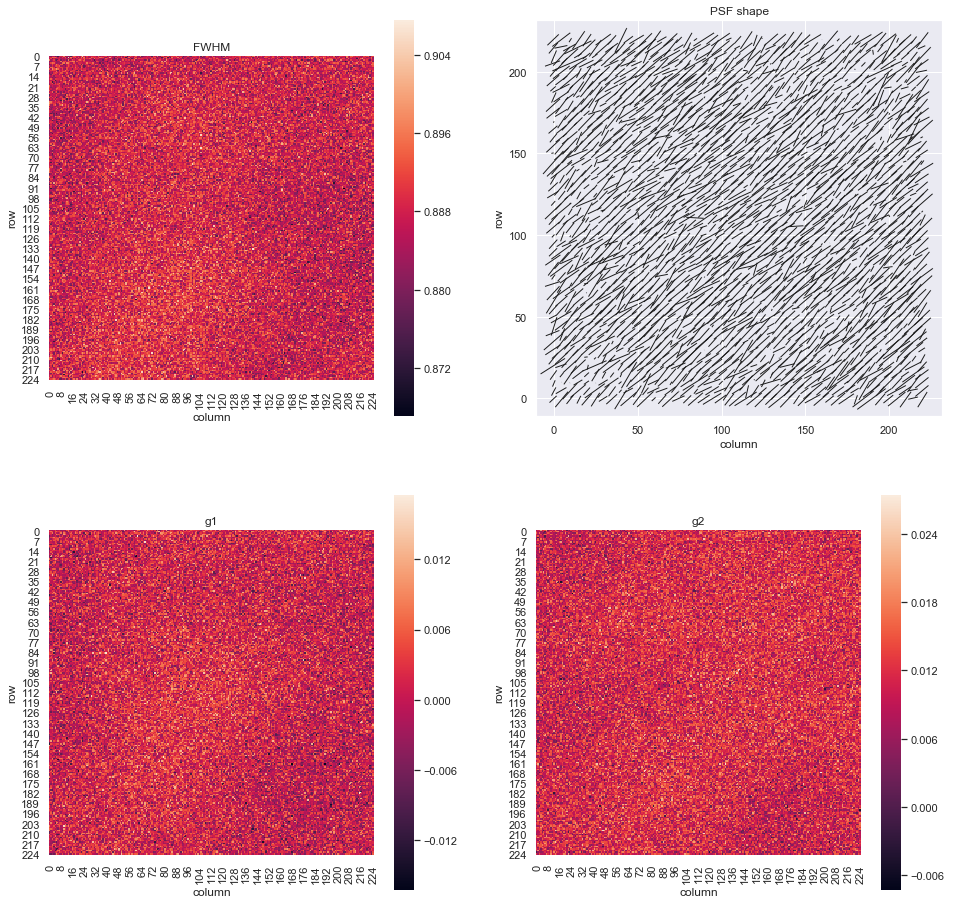

In [58]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

kwargs = {}
sns.heatmap(fwhms, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

g = np.sqrt(g1**2 + g2**2)
g /= np.mean(g)
loc = np.arange(g.shape[0]) + 0.5
beta = np.arctan2(g2, g1)/2
axs[0, 1].quiver(
    loc[::5],
    loc[::5],
    (g * np.cos(beta))[::5, ::5],
    (g * np.sin(beta))[::5, ::5],
    scale_units='xy',
    scale=0.075,
    headwidth=0,
    pivot='mid')
axs[0, 1].set_xlabel('column')
axs[0, 1].set_ylabel('row')
axs[0, 1].set_title('PSF shape')

sns.heatmap(g1, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')

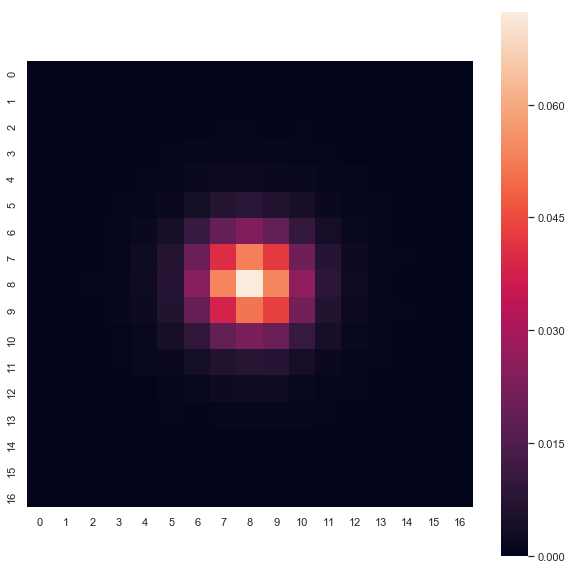

In [64]:
ims = d['flat_image'].reshape(225, 225, 17, 17)
msk = g1 == np.max(g1)
plt.figure(figsize=(10, 10))
sns.heatmap(ims[msk][0], square=True)

In [63]:
ims[msk].shape

(1, 17, 17)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])